In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("ggplot")

# Corrrecting accumulated rainfall data

Based on question from Uta in the `Coding and data analysis` Teams channel:

> I have a time series from a precipitation sensor that is basically a growth curve. But every time the instrument is serviced (several times a year) the curve has a set-back. That is because the water is collected in a bucket that has to be emptied out regularly. I (or rather Xiang) basically needs removed the set-backs and ideally yearly curves starting at zero at 1.1.yyyy 00:00.

This notebook generates synthetic data similar to Uta's example and corrects the offsets introduced by bucket emptying. 

In [2]:
def generate_example_data(
    start_year=2014,
    end_year=2014,
    prop_rain=0.4,
    min_daily_rain=-3,
    max_daily_rain=10,
    n_empty=5,
    min_prop_emptied=0.7,
):
    """Create fake dataset of accumulated rainfall similar to Uta's data.

    The dataset has the following characteristics:
     - The water level generally increases over time, but occasionally
       decreases by a small amount (due to net evaporation or sensor
       uncertainty).
     - When the bucket is emptied, the water level drops significantly,
       but not necessarily to zero.
     - Some days are dry.

    Args
        start_year: Int. First year of daily timeseries.
        end_year: Int. Last year of daily timeseries.
        prop_rain: Float. Proportion of days with rainfall.
        min_daily_rain: Int. Minimum daily rainfall in mm. Negative values
            indicate net evaporation (or sensor uncertainty).
        max_daily_rain: Int. Maximum daily rainfall in mm.
        n_empty: Int. Number of emptying events.
        min_prop_emptied: Float. At each emptying event, the proportion of
            water emptied is a random number between this value and 1.

    Returns
        Dataframe with columns 'date' and 'level_mm'.
    """
    # Daily dates
    dates = pd.date_range(
        start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq="D"
    )

    # Generate rainfall. Proportion of days with rain = prop_rain
    rainfall = np.random.uniform(
        low=min_daily_rain, high=max_daily_rain, size=len(dates)
    )
    zero_rainfall_indices = np.random.choice(
        len(dates), size=int((1 - prop_rain) * len(dates)), replace=False
    )
    rainfall[zero_rainfall_indices] = 0
    level = np.cumsum(rainfall)
    level[level < 0] = 0

    # Simulate bucket emptying events
    emptying_indices = np.random.choice(len(dates), size=n_empty, replace=False)
    emptying_indices.sort()
    for idx in emptying_indices:
        reduction = level[idx] * np.random.uniform(min_prop_emptied, 1.0)
        level[idx:] -= reduction

    return pd.DataFrame({"date": dates, "rainfall_mm": rainfall, "level_mm": level})


def correct_data(data, max_drop_mm=20):
    """For each year in 'data', sudden drops in water level greater than
    'max_drop_mm' are assumed to be bucket emptying events. These offsets
    are corrected.

    Args
        data: DataFrame. Must have columns 'date' (with datetime type) and
            'level_mm'.
        max_drop_mm: Float. Maximum allowable decrease due to evaporation or
            instrument uncertainty. Decreases larger than this are assumed
            to represent bucket emptying and will be corrected.

    Returns
        DataFrame with cumulative values for each year, indexed by day of year.
    """
    df["year"] = df["date"].dt.year
    df["day_of_year"] = df["date"].dt.dayofyear

    df_list = []
    for year in df["year"].unique():
        ann_df = df.query("year == @year").reset_index(drop=True)
        corrected = ann_df["level_mm"].copy()

        # Adjust levels so each year starts from zero
        init_level = corrected[0]
        corrected -= init_level

        # Correct offsets due to bucket emptying
        for i in range(1, len(corrected)):
            change = corrected[i] - corrected[i - 1]
            if change < -max_drop_mm:
                # Assume bucket emptied
                correction = corrected[i - 1] - corrected[i]
                corrected[i:] += correction

        ann_df[f"{year}_corrected_level_mm"] = corrected
        df_list.append(
            ann_df[["day_of_year", f"{year}_corrected_level_mm"]].set_index(
                "day_of_year"
            )
        )
    cor_df = pd.concat(df_list, axis="columns").reset_index()

    return cor_df

## 1. Generate example data for testing

,date,rainfall_mm,level_mm
0,2014-01-01,0.000000,0.000000
1,2014-01-02,9.729810,9.729810
2,2014-01-03,0.000000,9.729810
3,2014-01-04,0.000000,9.729810
4,2014-01-05,6.369686,16.099496


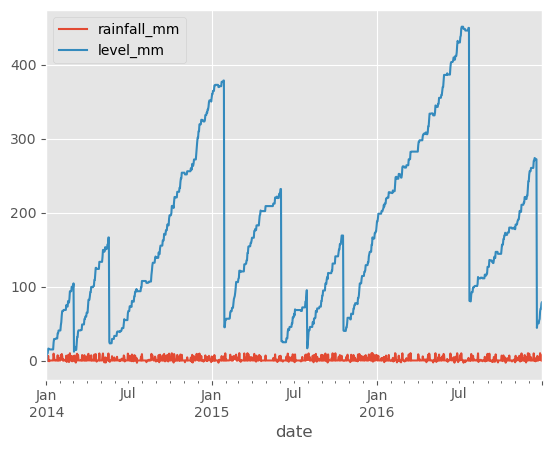

In [3]:
# Replace this with reading the 'real' data
df = generate_example_data(start_year=2014, end_year=2016, n_empty=8)
df.set_index("date").plot()
df.head()

## 2. Correct data

Remove offsets due to bucket emptying and start each annual curve from zero.

,day_of_year,2014_corrected_level_mm,2015_corrected_level_mm,2016_corrected_level_mm
0,1,0.000000,0.000000,0.000000
1,2,9.729810,4.999650,0.000000
2,3,9.729810,4.999650,4.133325
3,4,9.729810,9.186835,10.419233
4,5,16.099496,9.186835,10.419233


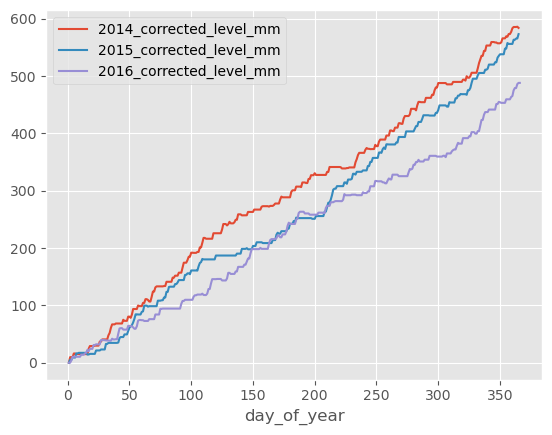

In [4]:
cor_df = correct_data(df, max_drop_mm=20)
cor_df.set_index("day_of_year").plot()
cor_df.head()